# Chapter 6 - Linear Model Selection and Regularization

- [Lab 2: Ridge Regression](#6.6.1-Ridge-Regression)
- [Lab 2: The Lasso](#6.6.2-The-Lasso)

In [1]:
%load_ext autoreload
%autoreload 2
import sys

In [2]:
# %load ../standard_import.txt`
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# conda install -c conda-forge glmnet
# import glmnet as gln

from sklearn.preprocessing import scale 
from sklearn import model_selection

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

#from sklearn.decomposition import PCA
#rom sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

#import sklearn.linear_model as skl_lm
#from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import  LeaveOneOut, KFold, cross_val_score


%matplotlib inline
plt.style.use('seaborn-white')

# Lab 2

In [4]:
# Dataset from package 'ISLR' to a csv file.
df = pd.read_csv('/Users/iordan/Documents/Statistics/Hunter/Data Science_STAT724/2020/data/Hitters.csv', index_col=0).dropna()
# df = pd.read_csv('../data/Hitters.csv', index_col=0).dropna()
df.index.name = 'Player'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [5]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Player,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [6]:
dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
dummies.info()
print(dummies.head())

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   League_A     263 non-null    uint8
 1   League_N     263 non-null    uint8
 2   Division_E   263 non-null    uint8
 3   Division_W   263 non-null    uint8
 4   NewLeague_A  263 non-null    uint8
 5   NewLeague_N  263 non-null    uint8
dtypes: uint8(6)
memory usage: 3.6+ KB
                   League_A  League_N  Division_E  Division_W  NewLeague_A  \
Player                                                                       
-Alan Ashby               0         1           0           1            0   
-Alvin Davis              1         0           0           1            1   
-Andre Dawson             0         1           1           0            0   
-Andres Galarraga         0         1           1           0            0   
-Alfredo Griffin          1         0           0    

In [7]:
y = df.Salary

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
#X.info()

In [8]:
X.head(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Player,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
-Alvin Davis,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0


#### Split to training/test sets.

In [9]:
#X_train = pd.read_csv('Data/Hitters_X_train.csv', index_col=0)
#y_train = pd.read_csv('Data/Hitters_y_train.csv', index_col=0)
#X_test = pd.read_csv('Data/Hitters_X_test.csv', index_col=0)
#y_test = pd.read_csv('Data/Hitters_y_test.csv', index_col=0)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y)  # test_size=t_prop, random_state=Y[i,j])


### 6.6.1 Ridge Regression

### Scikit-learn

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:
### $$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to
### $$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$
The __sklearn Ridge()__ function optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$
    
Simialarly, there is a sklearn function for LASSO - see further down.

In [26]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas = 10**np.linspace(2,-2,100)*0.5

In [27]:
alphas

array([5.00000000e+01, 4.55581378e+01, 4.15108784e+01, 3.78231664e+01,
       3.44630605e+01, 3.14014572e+01, 2.86118383e+01, 2.60700414e+01,
       2.37540508e+01, 2.16438064e+01, 1.97210303e+01, 1.79690683e+01,
       1.63727458e+01, 1.49182362e+01, 1.35929412e+01, 1.23853818e+01,
       1.12850986e+01, 1.02825615e+01, 9.36908711e+00, 8.53676324e+00,
       7.77838072e+00, 7.08737081e+00, 6.45774833e+00, 5.88405976e+00,
       5.36133611e+00, 4.88504979e+00, 4.45107543e+00, 4.05565415e+00,
       3.69536102e+00, 3.36707533e+00, 3.06795364e+00, 2.79540509e+00,
       2.54706901e+00, 2.32079442e+00, 2.11462144e+00, 1.92676430e+00,
       1.75559587e+00, 1.59963357e+00, 1.45752653e+00, 1.32804389e+00,
       1.21006413e+00, 1.10256537e+00, 1.00461650e+00, 9.15369140e-01,
       8.34050269e-01, 7.59955541e-01, 6.92443186e-01, 6.30928442e-01,
       5.74878498e-01, 5.23807876e-01, 4.77274228e-01, 4.34874501e-01,
       3.96241449e-01, 3.61040451e-01, 3.28966612e-01, 2.99742125e-01,
      

In [28]:
ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)

In [29]:
coefs

[array([-23.38692143,  67.26353481,  -7.54561073,  29.87611594,
         21.76662157,  49.62294402, -16.94961798,  20.75213404,
         56.33412498,  45.78076075,  57.37543924,  59.15884777,
        -16.43540657,  65.22827834,  12.41897939, -18.40543187,
         19.39179721, -55.64249114,  -0.99103297]),
 array([-27.62413531,  70.34930857,  -8.31082497,  29.90477447,
         21.6541451 ,  51.00811334, -19.06664468,  19.84271569,
         58.25557428,  46.71700125,  59.47790411,  60.97014134,
        -19.87899622,  66.15184379,  13.22969942, -19.01339108,
         20.0100054 , -56.36080357,  -1.60749534]),
 array([-32.14521071,  73.6326402 ,  -9.02353785,  29.89845319,
         21.53022238,  52.46368813, -21.20510655,  18.82461489,
         60.26246096,  47.64156933,  61.71625965,  62.82435619,
        -23.50090044,  67.02376225,  14.06722587, -19.60159833,
         20.62547489, -57.02673942,  -2.2381372 ]),
 array([-36.9539208 ,  77.12348833,  -9.67716777,  29.85236975,
         21.

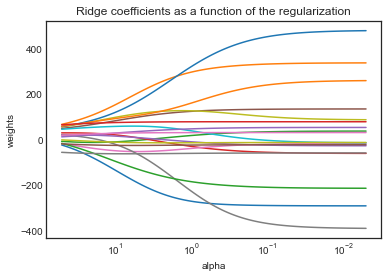

In [30]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### Alpha = 4

In [33]:
import sklearn.preprocessing as prepro

In [34]:
#prepro.scale?

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [36]:
len(X_)*11498/2

1511987.0

In [37]:
ridge2 = Ridge(alpha=len(X_)*11498/2)
ridge2.fit(scaler.transform(X_train), y_train)

Ridge(alpha=1511987.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [39]:
sc_t = scaler.transform(X_train)

In [40]:
sc_t

array([[ 0.91106117,  0.85199029,  1.26842078, ...,  1.06831847,
        -1.01534617,  1.05748739],
       [ 0.80965676,  0.6994858 ,  0.47479453, ...,  1.06831847,
        -1.01534617,  1.05748739],
       [ 1.00570529,  1.37486284,  0.13466899, ...,  1.06831847,
        -1.01534617,  1.05748739],
       ...,
       [ 1.06654794,  1.15699928,  1.60854631, ...,  1.06831847,
         0.98488578,  1.05748739],
       [-0.77225209, -0.69484099, -0.54558208, ...,  1.06831847,
         0.98488578,  1.05748739],
       [ 0.56628617,  0.80841758, -0.09208136, ...,  1.06831847,
        -1.01534617, -0.94563776]])

In [42]:
pred = ridge2.predict(scaler.transform(X_test))
mean_squared_error(y_test, pred)

221732.13908217623

In [21]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat          0.024566
Hits           0.026935
HmRun          0.020239
Runs           0.026807
RBI            0.026847
Walks          0.025027
Years          0.023675
CAtBat         0.030774
CHits          0.032225
CHmRun         0.031726
CRuns          0.032711
CRBI           0.033576
CWalks         0.027063
PutOuts        0.016062
Assists       -0.000453
Errors        -0.002427
League_N      -0.001907
Division_W    -0.012482
NewLeague_N    0.000341
dtype: float64

#### Alpha = $10^{10}$ 
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [22]:
ridge2.set_params(alpha=10**10)
ridge2.fit(scale(X_train), y_train)
pred = ridge2.predict(scale(X_test))
mean_squared_error(y_test, pred)

221891.9438567957

### Compute the regularization path using RidgeCV

In [25]:
RidgeCV?

Init signature:
RidgeCV(
    alphas=(0.1, 1.0, 10.0),
    fit_intercept=True,
    normalize=False,
    scoring=None,
    cv=None,
    gcv_mode=None,
    store_cv_values=False,
)
Docstring:     
Ridge regression with built-in cross-validation.

See glossary entry for :term:`cross-validation estimator`.

By default, it performs Generalized Cross-Validation, which is a form of
efficient Leave-One-Out cross-validation.

Read more in the :ref:`User Guide <ridge_regression>`.

Parameters
----------
alphas : numpy array of shape [n_alphas]
    Array of alpha values to try.
    Regularization strength; must be a positive float. Regularization
    improves the conditioning of the problem and reduces the variance of
    the estimates. Larger values specify stronger regularization.
    Alpha corresponds to ``C^-1`` in other linear models such as
    LogisticRegression or LinearSVC.
    If using generalized cross-validation, alphas must be positive.

fit_intercept : boolean
    Whether to calculat

In [31]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

RidgeCV(alphas=array([5.00000000e+01, 4.55581378e+01, 4.15108784e+01, 3.78231664e+01,
       3.44630605e+01, 3.14014572e+01, 2.86118383e+01, 2.60700414e+01,
       2.37540508e+01, 2.16438064e+01, 1.97210303e+01, 1.79690683e+01,
       1.63727458e+01, 1.49182362e+01, 1.35929412e+01, 1.23853818e+01,
       1.12850986e+01, 1.02825615e+01, 9.36908711e+00, 8.53676324e+00,
       7.77838072e+00, 7.08737081e+0...
       2.01850863e-02, 1.83918989e-02, 1.67580133e-02, 1.52692775e-02,
       1.39127970e-02, 1.26768225e-02, 1.15506485e-02, 1.05245207e-02,
       9.58955131e-03, 8.73764200e-03, 7.96141397e-03, 7.25414389e-03,
       6.60970574e-03, 6.02251770e-03, 5.48749383e-03, 5.00000000e-03]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring='neg_mean_squared_error', store_cv_values=False)

In [32]:
ridgecv.alpha_

4.8850497864961255

In [43]:
ridge2.set_params(alpha=ridgecv.alpha_)
ridge2.fit(scale(X_train), y_train)
mean_squared_error(y_test, ridge2.predict(scale(X_test)))
# 97384.92959172592

136447.0212663322

In [44]:
pd.Series(ridge2.coef_.flatten(), index=X.columns)

AtBat         -121.128318
Hits           134.851065
HmRun          -37.829244
Runs            69.250750
RBI              3.528483
Walks           87.714577
Years          -29.831955
CAtBat         -52.552374
CHits          120.914360
CHmRun          83.679207
CRuns          130.011831
CRBI           128.286319
CWalks        -173.988156
PutOuts         55.096126
Assists          5.809031
Errors         -30.675510
League_N        11.741999
Division_W     -71.668209
NewLeague_N     12.738169
dtype: float64

### 6.6.2 The Lasso

### Scikit-learn



For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

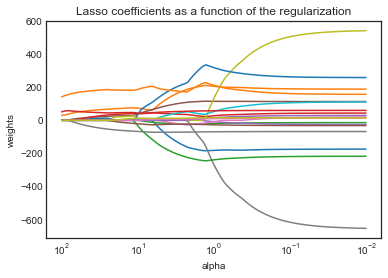

In [45]:
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas*2:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

In [46]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), y_train.values.ravel())

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=10000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [47]:
lassocv.alpha_

2.765779540923672

In [48]:
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
mean_squared_error(y_test, lasso.predict(scale(X_test)))

134885.5102814221

In [49]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

AtBat         -141.188123
Hits           170.856360
HmRun          -23.002627
Runs            36.081576
RBI             -0.000000
Walks          103.187576
Years          -23.242484
CAtBat          -0.000000
CHits            0.000000
CHmRun          46.102692
CRuns          210.765477
CRBI           174.362408
CWalks        -210.764000
PutOuts         53.439380
Assists          0.000000
Errors         -23.125649
League_N         7.915204
Division_W     -71.560426
NewLeague_N     12.471123
dtype: float64

#### Note that some of the estimated coefficients (Runs, RBI, CatBat, CHits and League_N), unlike in Ridge regression, are 0.